In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import multiprocessing as mp
from itertools import repeat
import pickle

In [3]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams.update({'font.size': 18})

# Definition of ODEs

In [22]:
def dOS(OS, p):
        
    oct4 = (p['s_1'] * OS**p['g_OS']) / ((p['k_1'] + OS**p['g_OS']) * p['d_O'])
    sox2 = (p['s_2'] * OS**p['g_OS']) / ((p['k_2'] + OS**p['g_OS']) * p['d_S'])
    decay = p['d_OS'] * OS
    
    return p['u'] * (oct4 * sox2) - decay

In [23]:
def dN_base(N, OS, p):
        
    nanog = (p['s_4'] * N**p['g_N']) / (p['k_4'] + N**p['g_N'])
    os = (p['s_3'] * OS**p['g_OS']) / (p['k_3'] + OS**p['g_OS'])
    decay = p['d_N'] * N
    
    return nanog + os - decay

In [24]:
def dN_stoch(N, OS, p):
        
    noise = noise_term(N, p['sigma'])
    nanog = (p['s_4'] * N**p['g_N']) / (p['k_4'] + N**p['g_N'])
    os = (p['s_3'] * OS**p['g_OS']) / (p['k_3'] + OS**p['g_OS'])
    decay = p['d_N'] * N
    
    return nanog + os - decay + noise

In [25]:
def dN_osc(N, OS, X, p):
        
    noise = noise_term(N, p['sigma'])
    nanog = (p['s_4'] * N**p['g_N']) / (p['k_4'] + N**p['g_N'] + p['s_6'] * X**p['g_X'])
    os = (p['s_3'] * OS**p['g_OS']) / (p['k_3'] + OS**p['g_OS'])
    decay = p['d_N'] * N
    
    return nanog + os - decay + noise

In [26]:
def dX(X, N, p):
    
    return ((p['s_5'] * N**p['g_N']) / (p['k_5'] + N**p['g_N'])) - p['d_X'] * X

In [27]:
def noise_term(N, sigma):
        
    return N * np.random.normal(0, sigma)

In [28]:
def base_model(y, dt, args):
    
    N, OS = y

    N += dt * dN_base(N, OS, args)
    OS += dt * dOS(OS, args)
    
    return [N, OS]

In [29]:
def stoch_model(y, dt, args):

    N, OS = y
    
    N += dt * dN_stoch(N, OS, args)
    OS += dt * dOS(OS, args)
    
    return [N, OS] if N >= 0 else [0, OS]

In [30]:
def osc_model(y, dt, args):

    N, OS, X = y
    
    N += dt * dN_osc(N, OS, X, args)
    OS += dt * dOS(OS, args)
    X += dt * dX(X, N, args)
    
    return [N, OS, X] if N >= 0 else [0, OS, X]

In [31]:
def _solve(model, tf, y0, dt, args):
    
    t_norm_factor = args['f']
    steps = int(tf*t_norm_factor / dt)
    
    t = np.linspace(0, tf, steps)
    y = []
    
    for i in range(steps):
        _y = y[i-1] if i > 0 else y0
        y.append(model(_y, dt, args))
        
    return {'t': np.asarray(t), 'y': np.asarray(y)}

# Definition of Model Parameters

In [32]:
params_stoch = {
    "u":     0.03,
    "s_1":   50,
    "s_2":   50,
    "s_3":   0.1,
    "s_4":   14,
    "k_1":   10,
    "k_2":   10,
    "k_3":   10,
    "k_4":   10,
    "d_O":   1, 
    "d_S":   1,
    "d_OS":  1,
    "d_N":   1,
    "g_OS":  1,
    "g_N":   2,
    "sigma": 12,
    "f":     270
}

In [33]:
params_osc = {
    "u":     0.03,
    "s_1":   50,
    "s_2":   50,
    "s_3":   0.1,
    "s_4":   30,
    "s_5":   10.08,
    "s_6":   4.74,
    "k_1":   10,
    "k_2":   10,
    "k_3":   10,
    "k_4":   2,
    "k_5":   10,
    "d_O":   1, 
    "d_S":   1,
    "d_OS":  1,
    "d_N":   1,
    "d_X":   0.2,
    "g_OS":  1,
    "g_N":   2,
    "g_X":   1,
    "sigma": 0.3,
    "f":     16
}

# (1) Modelling Stochastic Scenario

## base model (no addition of stochastic term)

In [460]:
# simulation parameters
dt = 0.0001
tf = 0.1

# initial conditions
OS_0 = 53.117
N_0 = 1

In [461]:
res = _solve(
    base_model,    
    tf,
    [N_0, OS_0], 
    dt,
    params_stoch
)

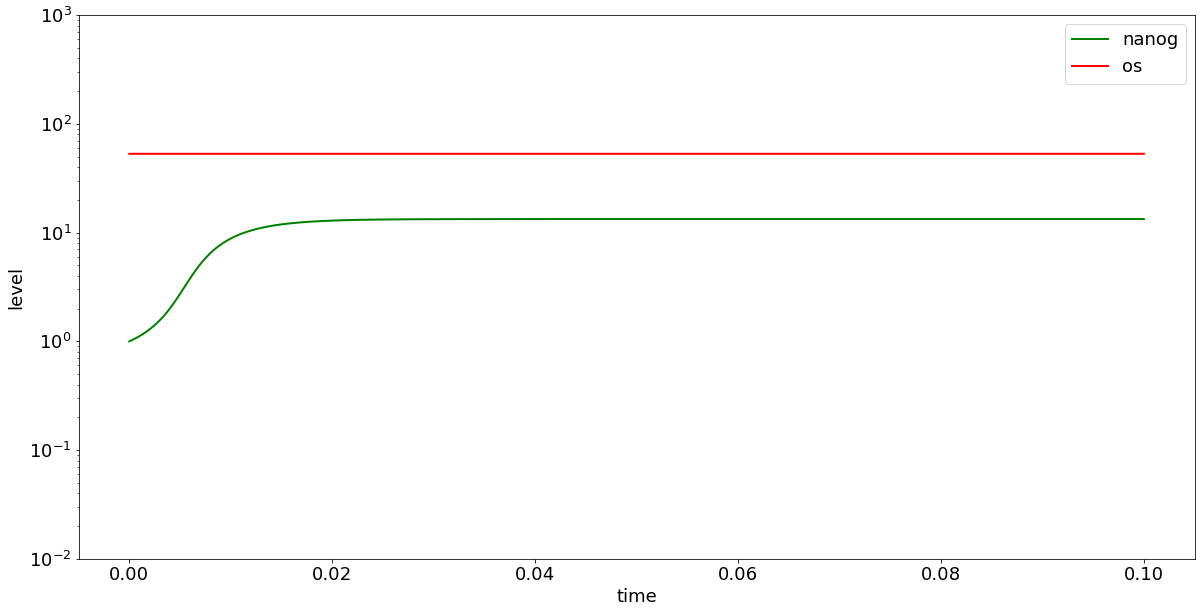

In [462]:
plt.plot(res['t'], res['y'].T[0], 'g-', linewidth=2, label='nanog')
plt.plot(res['t'], res['y'].T[1], 'r-', linewidth=2, label='os')
plt.xlabel('time')
plt.ylabel('level')
plt.ylim(bottom=0.01, top=1000)
plt.yscale("log")
plt.legend()
plt.show()

# Trajectory

In [463]:
# simulation parameters
dt = 0.0038
tf = 25

# initial conditions
OS_0 = 53.117
N_0 = 1

In [464]:
noise_traj = _solve(
    stoch_model, 
    tf, 
    [N_0, OS_0], 
    dt, 
    params_stoch
)

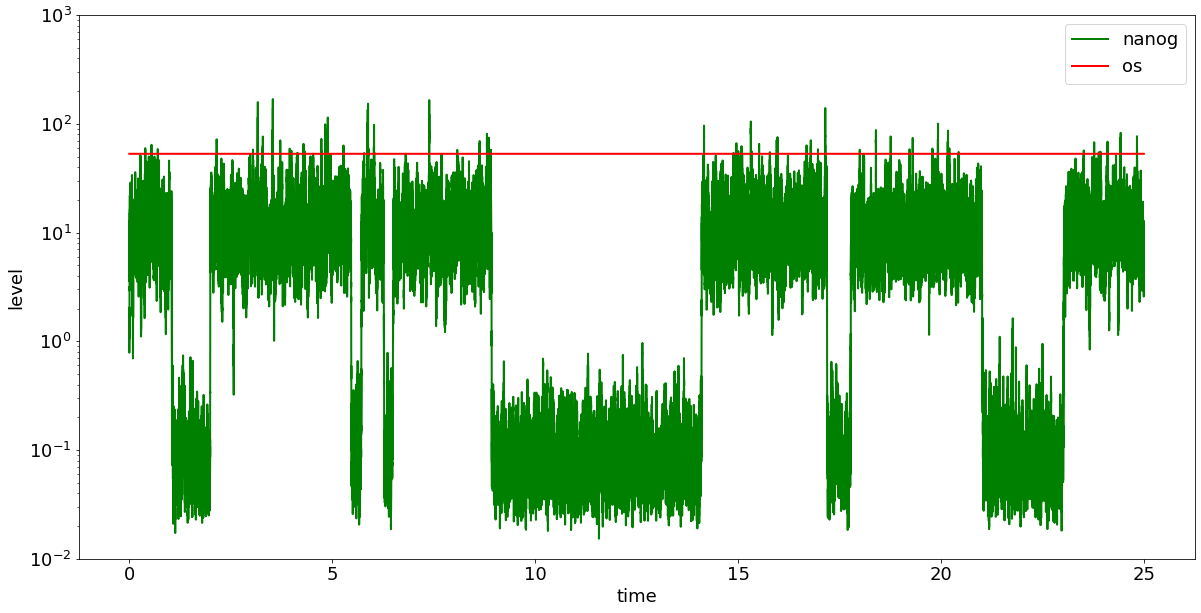

In [465]:
plt.plot(noise_traj['t'], noise_traj['y'].T[0], 'g-', linewidth=2, label='nanog')
plt.plot(noise_traj['t'], noise_traj['y'].T[1], 'r-', linewidth=2, label='os')
plt.xlabel('time')
plt.ylabel('level')
plt.ylim(bottom=10**-2, top=10**3)
plt.yscale("log")
plt.legend()
plt.show()

# Population Simulation

In [513]:
# simulation parameters
dt = 0.0038
tf = 0.1 # choose a way shorter tf here in order to minimize runtime for cell population simulation

# initial conditions
OS_0 = 53.117
N_0 = 1

# population parameter
num_cells = 5000

In [514]:
nanog_levels = []

for i in tqdm(range(num_cells)):
    res = _solve(
        stoch_model, 
        tf, 
        [N_0, OS_0], 
        dt, 
        params_stoch
    )

    # append only the last value for every cell (current nanog level at the and of simulation run)
    # to array of nanog values 
    nanog_levels.append(res['y'].T[0][-1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:18<00:00, 25.16it/s]


(0.01, 100)

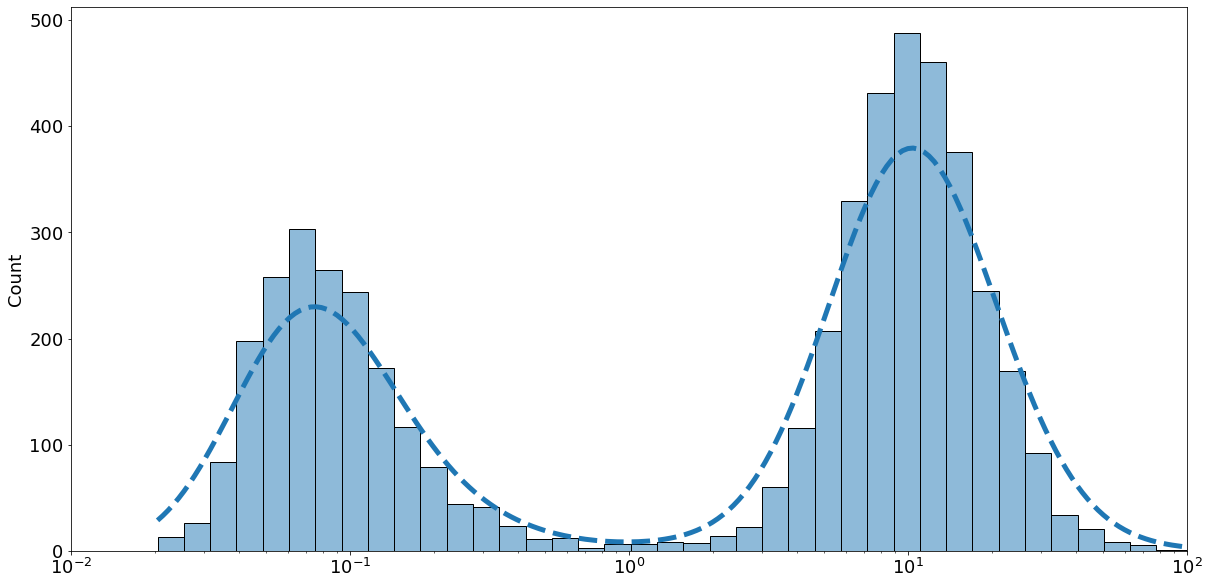

In [518]:
fig, ax = plt.subplots()
sns.histplot(np.asarray(nanog_levels), bins=40, ax=ax, kde=True, log_scale=True, line_kws={"lw":5, 'linestyle':'--'})
ax.set_xlim(10**-2, 10**2)

In [516]:
# save results to disk
np.save("./data/population_stoch", np.asarray(nanog_levels))

# Cell Population Simulation with varying values for sigma and s4

In [411]:
# simulation parameters
dt = 0.0038
tf = 0.1 # choose a way shorter tf here in order to minimize runtime for cell population simulation

# initial conditions
OS_0 = 53.117
N_0 = 1

# population parameter
num_cells = 5000

In [412]:
s4s = np.array([3240, 3780, 4050, 3780, 5400]) / params_stoch['f']
sigmas = np.array([12, 12, 12, 20, 20])

In [413]:
levels_over_combinations = {}

# run simulation for every s4 / sigma combination over n cells
for comb in zip(s4s, sigmas):
        
    _nanog_levels = []
    
    s4 = comb[0] 
    sigma = comb[1]

    print(f'solving for s4: {s4}, sigma: {sigma}')
    
    # substitute s4 and sigma in the base parameter configuration for the tweaked ones
    _params = params_stoch.copy()
    _params['s_4'] = s4
    _params['sigma'] = sigma
    
    for i in tqdm(range(num_cells)):
                
        res = _solve(
            stoch_model, 
            tf, 
            [N_0, OS_0], 
            dt, 
            _params
        )
        
        # append only the last value for every cell (current nanog level at the and of simulation run)
        # to array of nanog values 
        _nanog_levels.append(res['y'].T[0][-1])
    
    # append nanog values for every combination to dict and index by parameter s4 and sigma
    index = f"s4 = {comb[0] * params_stoch['f']} σ = {comb[1]}"
    levels_over_combinations[index] = np.asarray(_nanog_levels)

solving for s4: 12.0, sigma: 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:08<00:00, 20.11it/s]


solving for s4: 14.0, sigma: 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:08<00:00, 20.16it/s]


solving for s4: 15.0, sigma: 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:08<00:00, 20.14it/s]


solving for s4: 14.0, sigma: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:10<00:00, 19.98it/s]


solving for s4: 20.0, sigma: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:10<00:00, 19.97it/s]


In [426]:
# save data to disk
with open('./data/population_params_stoch.pkl', 'wb') as f:
    pickle.dump(levels_over_combinations, f)

<AxesSubplot:ylabel='Density'>

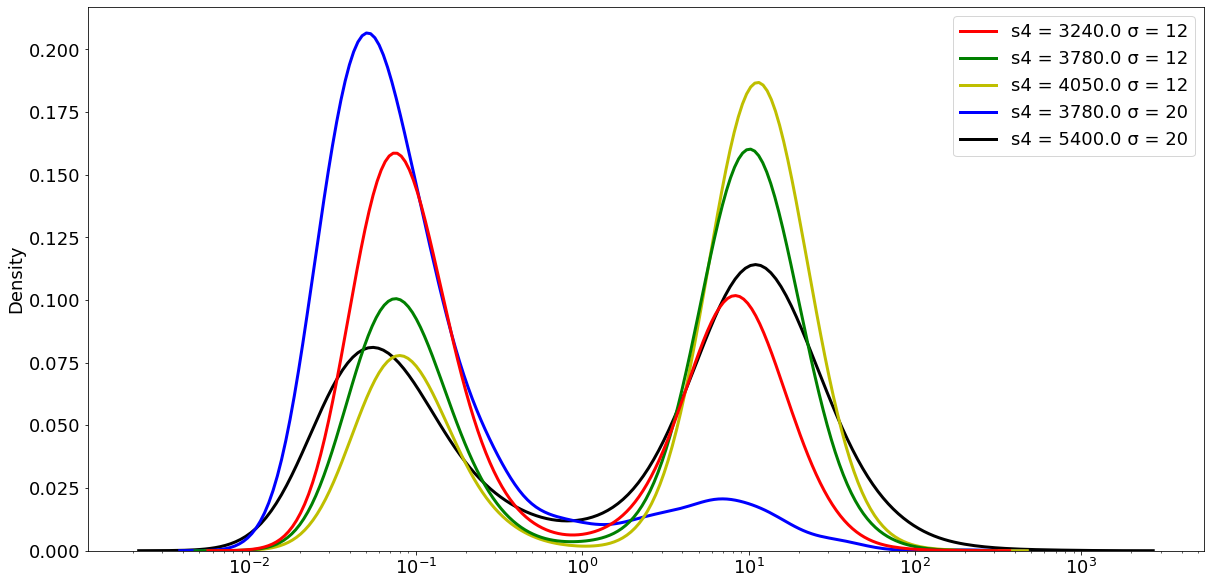

In [466]:
colors = ['r', 'g', 'y', 'b', 'black']
sns.kdeplot(data=levels_over_combinations, log_scale=(10, False), lw=3, palette=colors)

# (2) Oscillating scenario

# Trajectory

In [467]:
# simulation parameters
dt = 0.0038
tf = 25

# initial conditions
OS_0 = 53.117
N_0 = 30
X_0 = OS_0

In [468]:
osc_traj = _solve(
    osc_model, 
    tf, 
    [N_0, OS_0, X_0], 
    dt, 
    params_osc
)

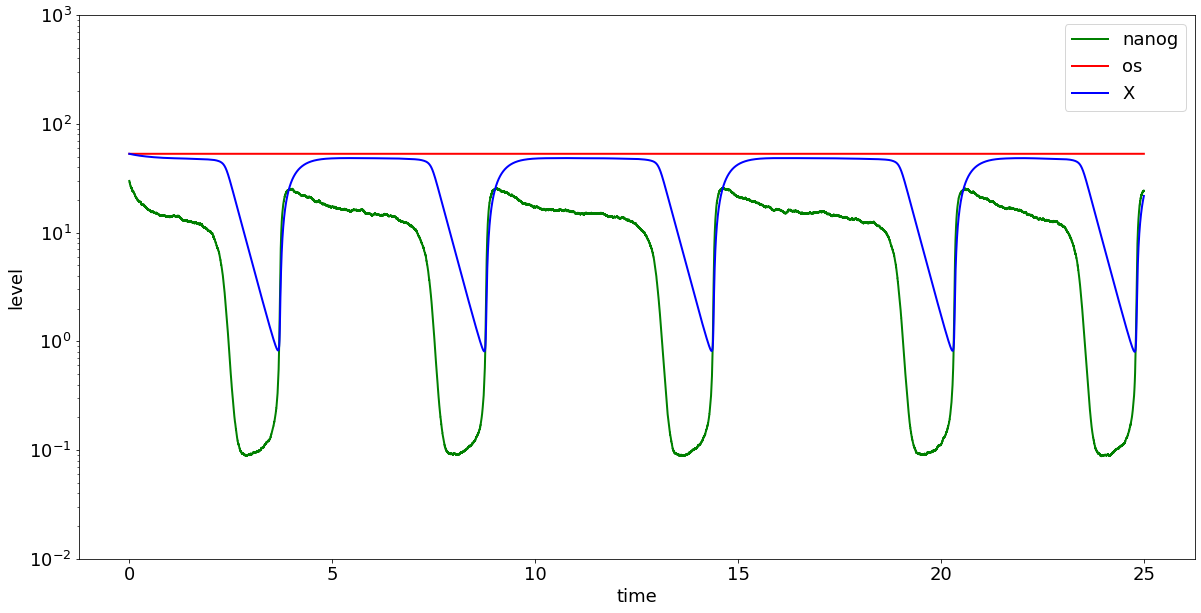

In [469]:
plt.plot(osc_traj['t'], osc_traj['y'].T[0], 'g-', linewidth=2, label='nanog')
plt.plot(osc_traj['t'], osc_traj['y'].T[1], 'r-', linewidth=2, label='os')
plt.plot(osc_traj['t'], osc_traj['y'].T[2], 'b-', linewidth=2, label='X')
plt.xlabel('time')
plt.ylabel('level')
plt.ylim(bottom=10**-2, top=10**3)
plt.yscale("log")
plt.legend()
plt.show()

# Phase Space

In [471]:
# simulation parameters
dt = 0.0025
tf = 25

# initial conditions
OS_0 = 53.117
N_0 = 0
X_0 = 0

In [472]:
res_noise = _solve(
    osc_model, 
    tf, 
    [N_0, OS_0, X_0], 
    dt, 
    params_osc
)

_params = params_osc.copy()
_params['sigma'] = 0

res_no_noise = _solve(
    osc_model, 
    tf, 
    [N_0, OS_0, X_0], 
    dt, 
    _params
)

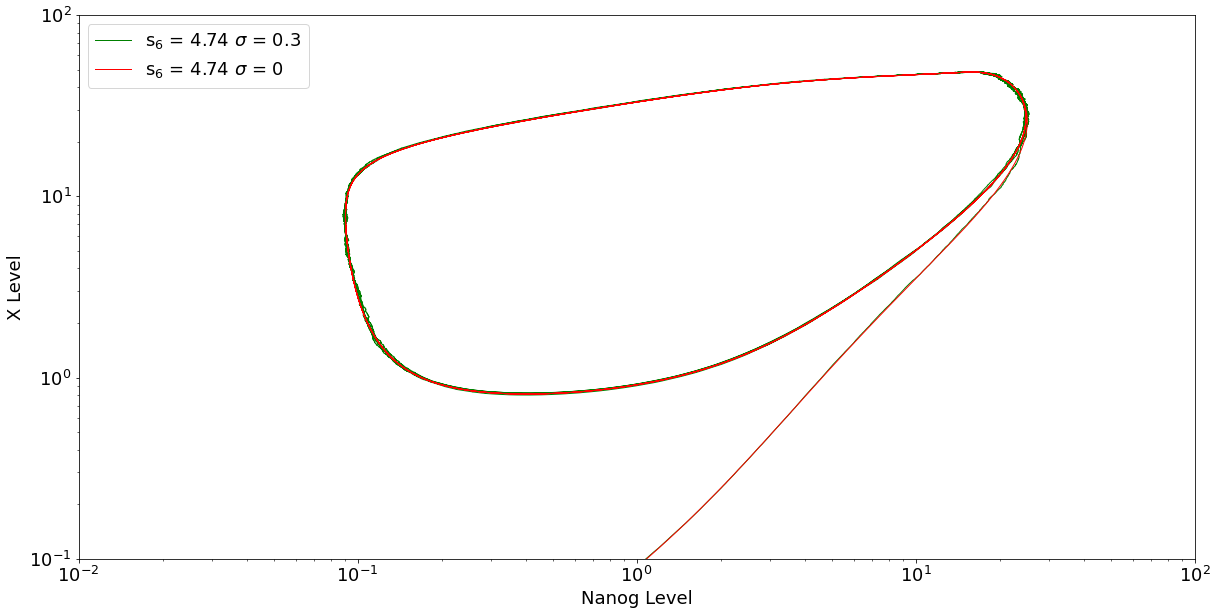

In [473]:
plt.plot(res_noise['y'].T[0], res_noise['y'].T[2], "g-",linewidth=1.0, label="s$_{6}$ = 4.74 $\sigma$ = 0.3")
plt.plot(res_no_noise['y'].T[0], res_no_noise['y'].T[2], "r-", linewidth=1.0, label="s$_{6}$ = 4.74 $\sigma$ = 0")
plt.xlabel("Nanog Level")
plt.ylabel("X Level")
plt.ylim(10**-1, 10**2)
plt.xlim(10**-2, 10**2)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="upper left")

# Population Simulation

### Simulations are computed in parallel from now on

In [569]:
# simulation parameters
dt = 0.0025
tf = 50

# initial conditions
OS_0 = 53.117
N_0 = 30
X_0 = OS_0

# population parameter
num_cells = 10000

In [570]:
# prepare inputs for parallel processor
args = (osc_model, tf, [N_0, OS_0, X_0], dt, params_osc)
inputs = zip(list(range(num_cells)), repeat(args))

# define function to be run in parallel
def solve_and_return_last_nanog_value(_, args):
    return _solve(*args)['y'].T[0][-1]

# run population simulation on all available cpus
with mp.Pool(mp.cpu_count()) as pool:
    _osc_nanog_levels = pool.starmap(solve_and_return_last_nanog_value, tqdm(inputs, total=num_cells), chunksize=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [57:54<00:00,  2.88it/s]


(0.01, 100)

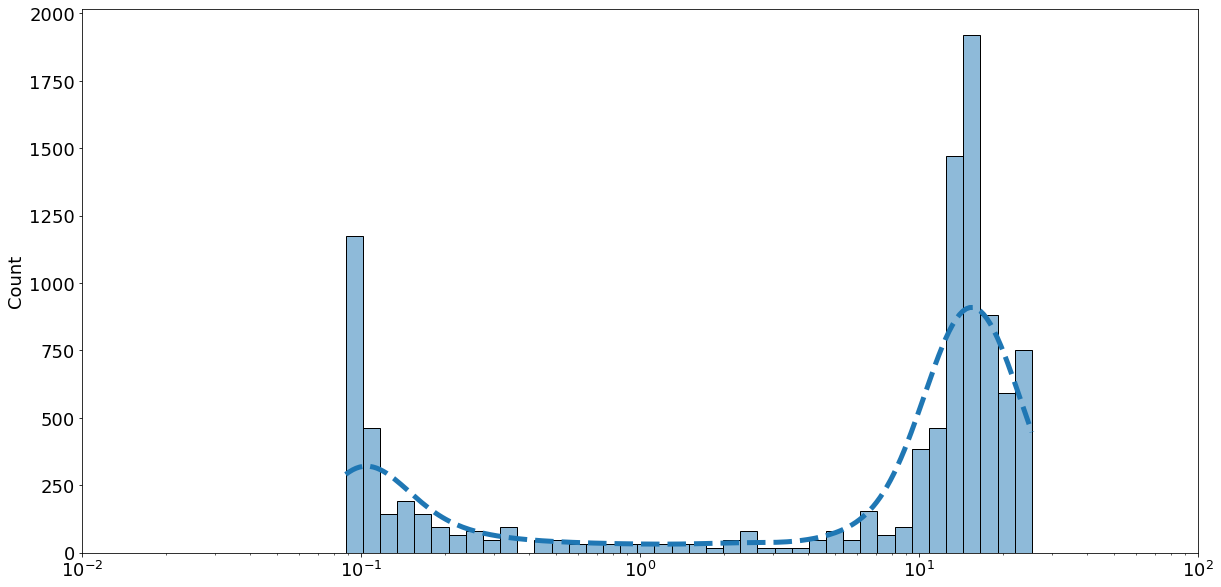

In [571]:
# plot levels on log scale
fig, ax = plt.subplots()
sns.histplot(np.asarray(_osc_nanog_levels), bins=40, ax=ax, kde=True, log_scale=True, line_kws={"lw":5, 'linestyle':'--'})
ax.set_xlim(10**-2, 10**2)

In [573]:
# save results to disk
np.save("./data/population_osc", np.asarray(_osc_nanog_levels))

# Cell Population Simulation with varying values for sigma and s6

In [415]:
# simulation parameters
dt = 0.0025
tf = 50

# initial conditions
OS_0 = 53.117
N_0 = 30
X_0 = OS_0

# population parameter
num_cells = 5000

In [416]:
s6s = np.array([10.0, 10.0, 5.0, 4.74, 4.74])
sigmas = np.array([3.0, 0.3, 0.3, 0.3, 3.0])

In [417]:
levels_over_combinations_osc = {}

# define function to be run in parallel
def solve_and_return_last_nanog_value(_, args):
    return _solve(*args)['y'].T[0][-1]

for comb in zip(s6s, sigmas):
        
    _nanog_levels = []
    
    s6 = comb[0] 
    sigma = comb[1]

    print(f'solving for s6: {s6}, sigma: {sigma}')
    
    # substitute s6 and sigma in the base parameter configuration for the tweaked ones
    _params = params_osc.copy()
    _params['s_6'] = s6
    _params['sigma'] = sigma
    
    # prepare inputs for parallel processor
    args = (osc_model, tf, [N_0, OS_0, X_0], dt, _params)
    inputs = zip(list(range(num_cells)), repeat(args))

    # run population simulation on all available cpus
    with mp.Pool(mp.cpu_count()) as pool:
        _osc_nanog_levels = pool.starmap(solve_and_return_last_nanog_value, tqdm(inputs, total=num_cells), chunksize=1)
    
    # append nanog values for every combination to dict and index by parameter s6 and sigma
    index = f"s6 = {comb[0]} σ = {comb[1]}"
    levels_over_combinations_osc[index] = np.asarray(_osc_nanog_levels)

solving for s6: 10.0, sigma: 3.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [38:32<00:00,  2.16it/s]


solving for s6: 10.0, sigma: 0.3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [37:02<00:00,  2.25it/s]


solving for s6: 5.0, sigma: 0.3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [36:26<00:00,  2.29it/s]


solving for s6: 4.74, sigma: 0.3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [36:36<00:00,  2.28it/s]


solving for s6: 4.74, sigma: 3.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [36:52<00:00,  2.26it/s]


In [422]:
# save data to disk
with open('./data/population_params_osc.pkl', 'wb') as f:
    pickle.dump(levels_over_combinations_osc, f)

<AxesSubplot:ylabel='Density'>

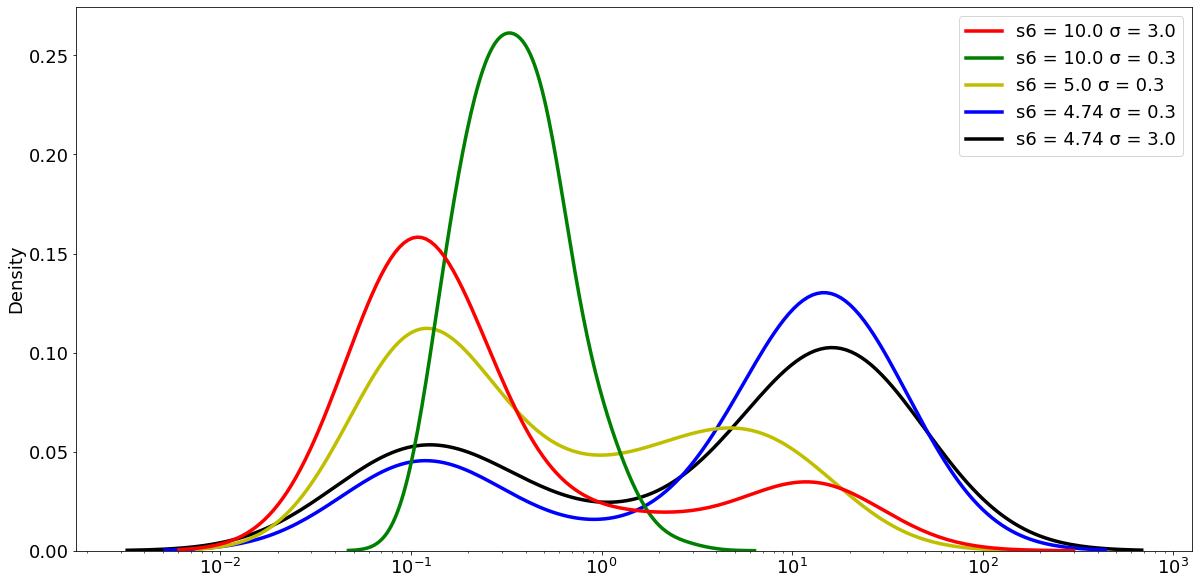

In [474]:
colors = ['r', 'g', 'y', 'b', 'black']
sns.kdeplot(data=levels_over_combinations_osc, log_scale=(10, False), bw_adjust=2.5, lw=3.5, palette=colors)

# Time courses of the re-establishment of the bimodal distribution

In [14]:
# define function for plotting results
def plt_timecourse(data, x_max, sample_times, title, skip_n=100):
    
    # calculate percentage of low cells over time course 
    _num_cells = data.shape[0]
    _num_steps = data.shape[1]
    n_low_percentages = np.asarray([_t[_t <= hi_lo_thresh].shape[0] / _num_cells for _t in data.T[::skip_n]])
    
    # subplots
    ax1 = plt.subplot(3, 4, 1)
    ax2 = plt.subplot(3, 4, 2)
    ax3 = plt.subplot(3, 4, 3)
    ax4 = plt.subplot(3, 4, 4)
    upper_axs = [ax1, ax2, ax3, ax4]
    ax_bottom = plt.subplot(3, 4, (5, 16))
    # dist_bins = np.logspace(np.log10(data.min()), np.log10(data.max()), 10)
    
    for ax in upper_axs:
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)    
    
    # data
    x = np.linspace(0, x_max, num=n_low_percentages.shape[0])
    y_high = (1 - n_low_percentages) * 100
    y_low = n_low_percentages * 100
    
    # dashed lines
    s_t_labels = ['I', 'II', 'III', 'IV']
    for idx, s_t in enumerate(sample_times):
        plt.axvline(s_t * x_max, color='grey',linestyle="--",lw=1.5)
        plt.text(s_t * x_max + 0.1, 103, s_t_labels[idx], fontsize=16, verticalalignment='top')

        # distribution at sampled time steps
        t_slice = int(s_t * _num_steps)
        _ax = upper_axs[idx]
        sns.histplot(data.T[t_slice], bins=30, ax=_ax, kde=False, log_scale=True)
        _ax.set_xlim(10**-2, 10**2)
        _ax.set_ylim(0, 800)
        _ax.set_title(s_t_labels[idx])
    
    # distribution over time curves
    ax_bottom.plot(x, y_low, 'r-', lw=1, label='Nanog-low')
    ax_bottom.plot(x, y_high, 'b-', lw=1, label='Nanog-high')
    
    # axis
    plt.ylabel("Cell number [%]")
    plt.xlabel("Time")
    plt.xlim(left=-0.5, right=10.5)
    plt.ylim(bottom=-5, top=105)
    
    # legend
    leg=plt.legend(loc="best",frameon=False,title=title)
    for l in leg.get_lines():
                l.set_linewidth(2.5)    

# (1) Stochastic Szenario

In [10]:
# simulation parameters
dt = 0.0038
tf_init = 0.1    # time to init start condition (after this time cells are sep. into nanog high / low)

tf_eval = 10     # end state of simulation 
hi_lo_thresh = 1 # threshold to distinguish between nanog high / low cells

sample_time_points = [.0, .05, .2, .8] # fraction ofs tf_eval at which distributions will be plotted

# initial conditions
OS_0 = 53.117
N_0 = 1

# population parameter
num_cells = 5000

In [535]:
# run simulation for tf_init-time to init population

# prepare inputs for parallel processor
args = (stoch_model, tf_init, [N_0, OS_0], dt, params_stoch)
inputs = zip(list(range(num_cells)), repeat(args))

# define function to be run in parallel
def solve_and_return_last_nanog_value(_, args):
    return _solve(*args)['y'].T[0][-1]

# run population simulation on all available cpus
with mp.Pool(mp.cpu_count()) as pool:
    init_state = np.asarray(pool.starmap(solve_and_return_last_nanog_value, tqdm(inputs, total=num_cells), chunksize=1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:32<00:00, 153.34it/s]


(0.01, 100)

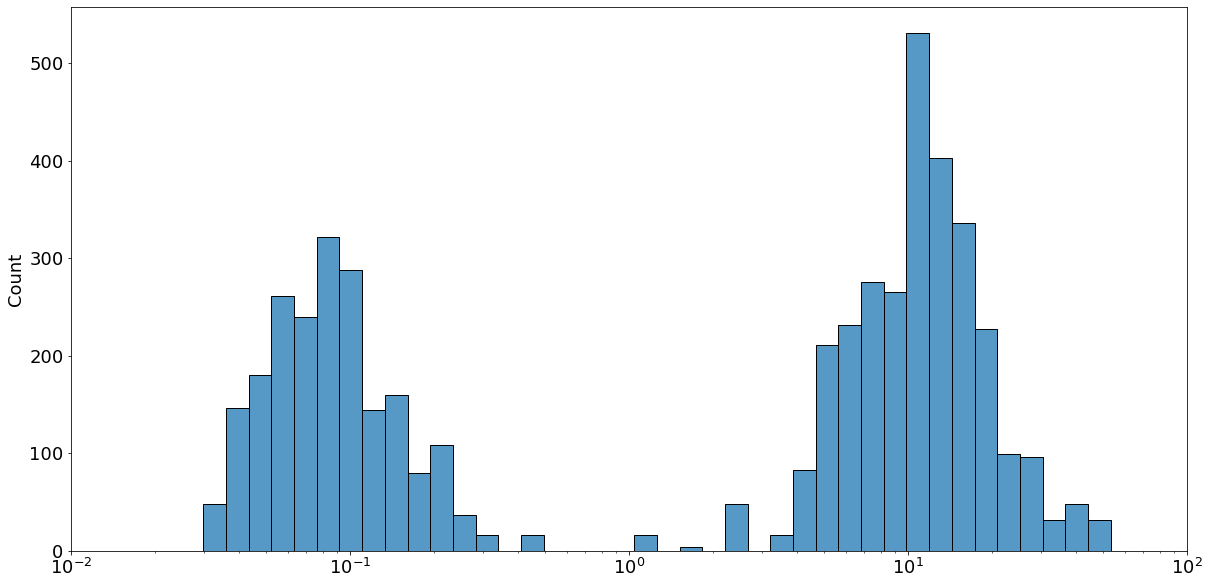

In [536]:
# plot nanog levels within population
fig, ax = plt.subplots()
sns.histplot(init_state, bins=40, ax=ax, log_scale=True)
ax.set_xlim(10**-2, 10**2)

In [537]:
# separate cells into nanog high / low
n_low_cells = init_state[init_state <= hi_lo_thresh]
n_high_cells = init_state[init_state > hi_lo_thresh]
print(n_low_cells.shape, n_high_cells.shape)

(2046,) (2954,)


### Now run two seperate simulations with only one specific cell type, and use the previously calculated nanog level as initial condition

In [538]:
# define function to be run in parallel
# this time return the whole trajectory not only the last values, so change over time can be displayed
def solve_and_return_nanog_values(_, args):
    return _solve(*args)['y'].T[0]

In [539]:
# nanog low
num_n_low_cells = n_low_cells.shape[0]

# prepare inputs for parallel processor
args = [(stoch_model, tf_eval, [n_low_cells[i], OS_0], dt, params_stoch) for i in range(num_n_low_cells)]
inputs = zip(list(range(num_n_low_cells)), args)

# run population simulation on all available cpus
with mp.Pool(mp.cpu_count()) as pool:
    t_course_n_low = np.asarray(pool.starmap(solve_and_return_nanog_values, tqdm(inputs, total=num_n_low_cells), chunksize=1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2046/2046 [44:12<00:00,  1.30s/it]


In [540]:
# save results to disk
np.save("./data/time_course_stoch_nanog_low", t_course_n_low)

In [4]:
# load results from disk
# t_course_n_low = np.load("./data/time_course_stoch_nanog_low.npy")

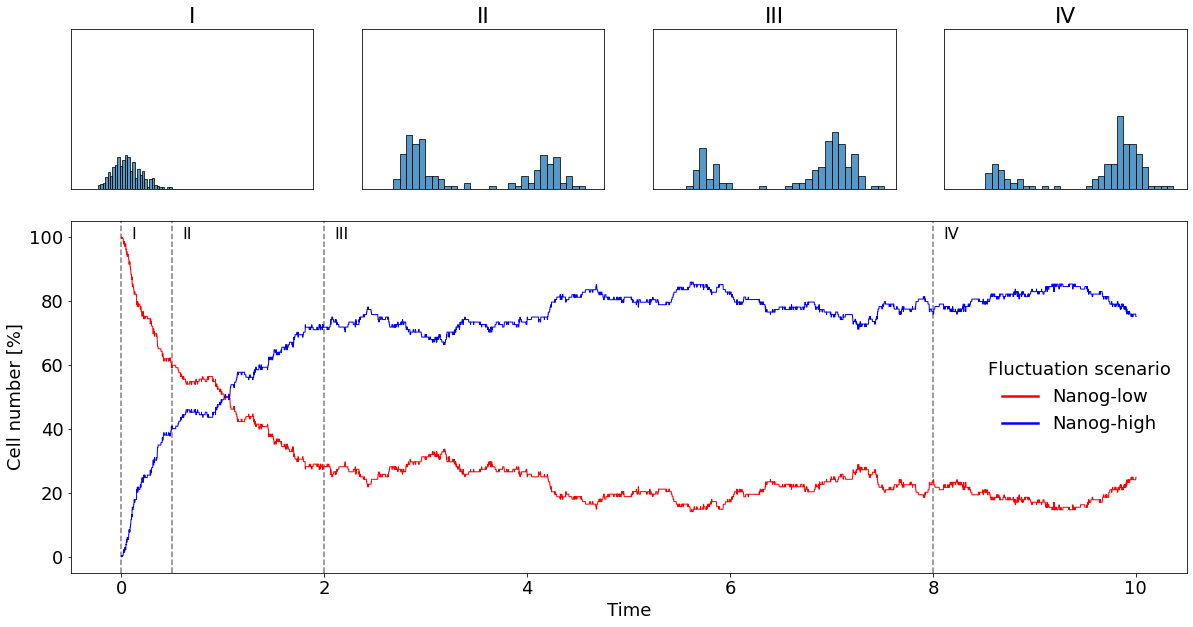

In [15]:
# plot results
plt_timecourse(t_course_n_low, 10, sample_time_points, 'Fluctuation scenario')

In [543]:
# nanog high
num_n_high_cells = n_high_cells.shape[0]

# prepare inputs for parallel processor
args = [(stoch_model, tf_eval, [n_high_cells[i], OS_0], dt, params_stoch) for i in range(num_n_high_cells)]
inputs = zip(list(range(num_n_high_cells)), args)

# run population simulation on all available cpus
with mp.Pool(mp.cpu_count()) as pool:
    t_course_n_high = np.asarray(pool.starmap(solve_and_return_nanog_values, tqdm(inputs, total=num_n_high_cells), chunksize=1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2954/2954 [57:04<00:00,  1.16s/it]


In [545]:
# save results to disk
np.save("./data/time_course_stoch_nanog_high", t_course_n_high)

In [16]:
# load results from disk
# t_course_n_high = np.load("./data/time_course_stoch_nanog_high.npy")

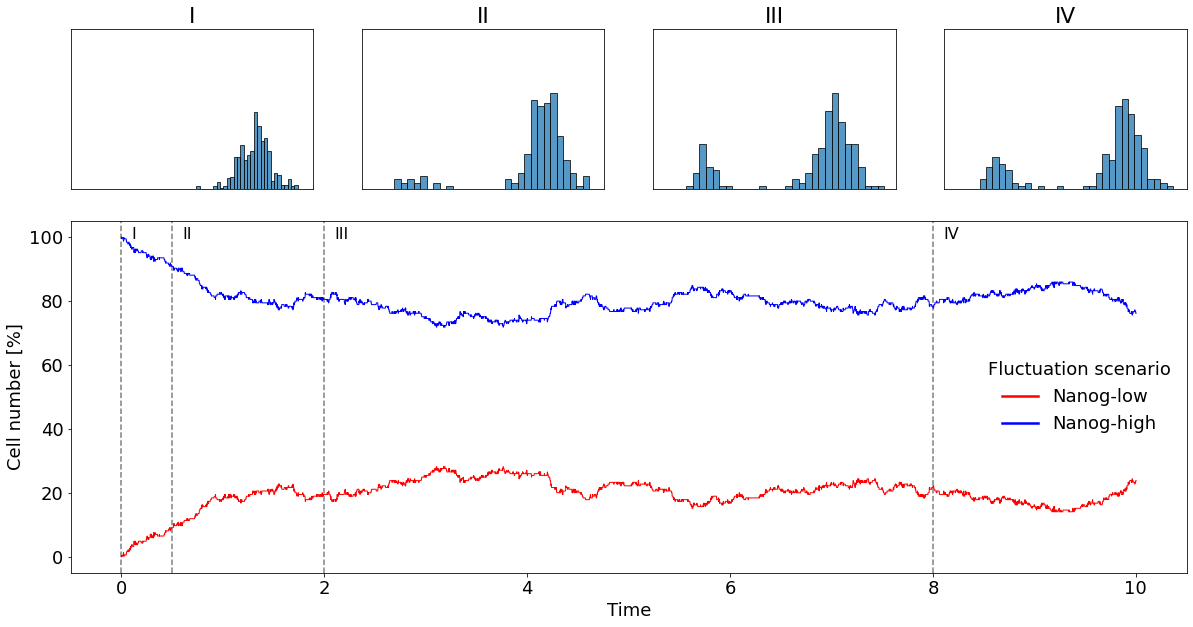

In [17]:
# plot results
plt_timecourse(t_course_n_high, 10, sample_time_points, 'Fluctuation scenario')

# (2) Oscillating Szenario

In [557]:
# simulation parameters
dt = 0.0025
tf_init = 25    # time to init start condition (after this time cells are sep. into nanog high / low)

tf_eval = 10     # end state of simulation 
hi_lo_thresh = 1 # threshold to distinguish between nanog high / low cells

# initial conditions
OS_0 = 53.117
N_0 = 30
X_0 = OS_0

# population parameter
num_cells = 5000

In [522]:
# run simulation for tf_init-time to init population

# prepare inputs for parallel processor
args = (osc_model, tf_init, [N_0, OS_0, X_0], dt, params_osc)
inputs = zip(list(range(num_cells)), repeat(args))

# define function to be run in parallel
def solve_and_return_last_nanog_value(_, args):
    return _solve(*args)['y'].T[0][-1]

# run population simulation on all available cpus
with mp.Pool(mp.cpu_count()) as pool:
    init_state = np.asarray(pool.starmap(solve_and_return_last_nanog_value, tqdm(inputs, total=num_cells), chunksize=1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:17<00:00,  6.27it/s]


(0.01, 100)

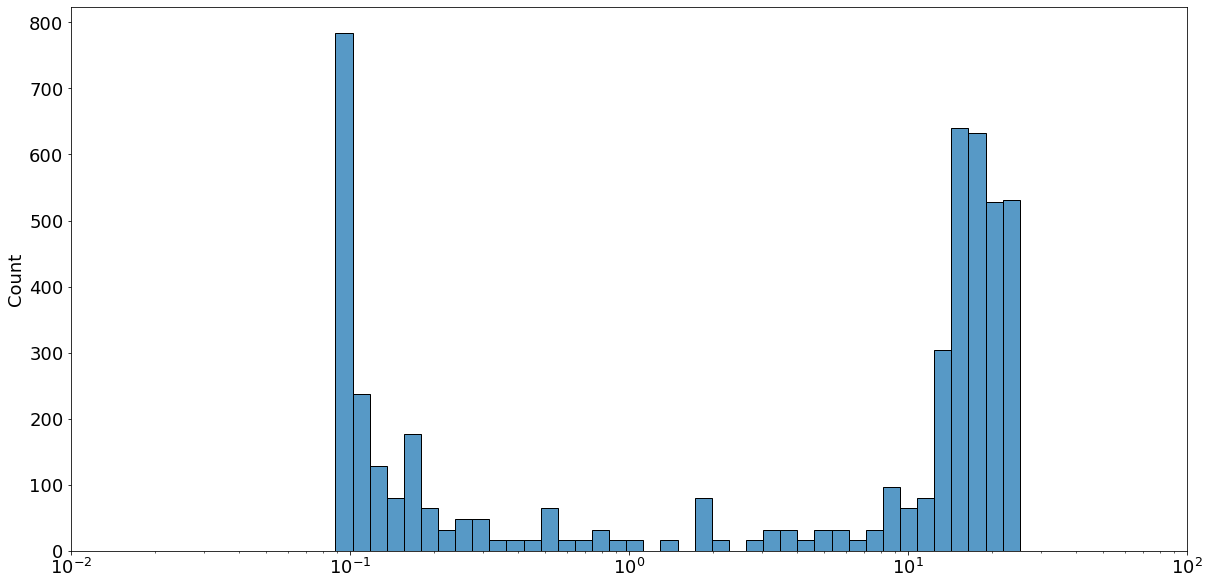

In [523]:
# plot nanog levels within population
fig, ax = plt.subplots()
sns.histplot(init_state, bins=40, ax=ax, log_scale=True)
ax.set_xlim(10**-2, 10**2)

In [524]:
# separate cells into nanog high / low
n_low_cells = init_state[init_state <= hi_lo_thresh]
n_high_cells = init_state[init_state > hi_lo_thresh]
print(n_low_cells.shape, n_high_cells.shape)

(1789,) (3211,)


### Now run two seperate simulations with only one specific cell type, and use the previously calculated nanog level as initial condition

In [525]:
# define function to be run in parallel
# this time return the whole trajectory not only the last values, so change over time can be displayed
def solve_and_return_nanog_values(_, args):
    return _solve(*args)['y'].T[0]

In [526]:
# nanog low
num_n_low_cells = n_low_cells.shape[0]

# prepare inputs for parallel processor
args = [(osc_model, tf_eval, [n_low_cells[i], OS_0, X_0], dt, params_osc) for i in range(num_n_low_cells)]
inputs = zip(list(range(num_n_low_cells)), args)

# run population simulation on all available cpus
with mp.Pool(mp.cpu_count()) as pool:
    t_course_osc_n_low = np.asarray(pool.starmap(solve_and_return_nanog_values, tqdm(inputs, total=num_n_low_cells), chunksize=1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1789/1789 [02:32<00:00, 11.71it/s]


In [527]:
# save results to disk
np.save("./data/time_course_osc_nanog_low", t_course_osc_n_low)

In [18]:
# load results from disk
# t_course_osc_n_low = np.load("./data/time_course_osc_nanog_low.npy")

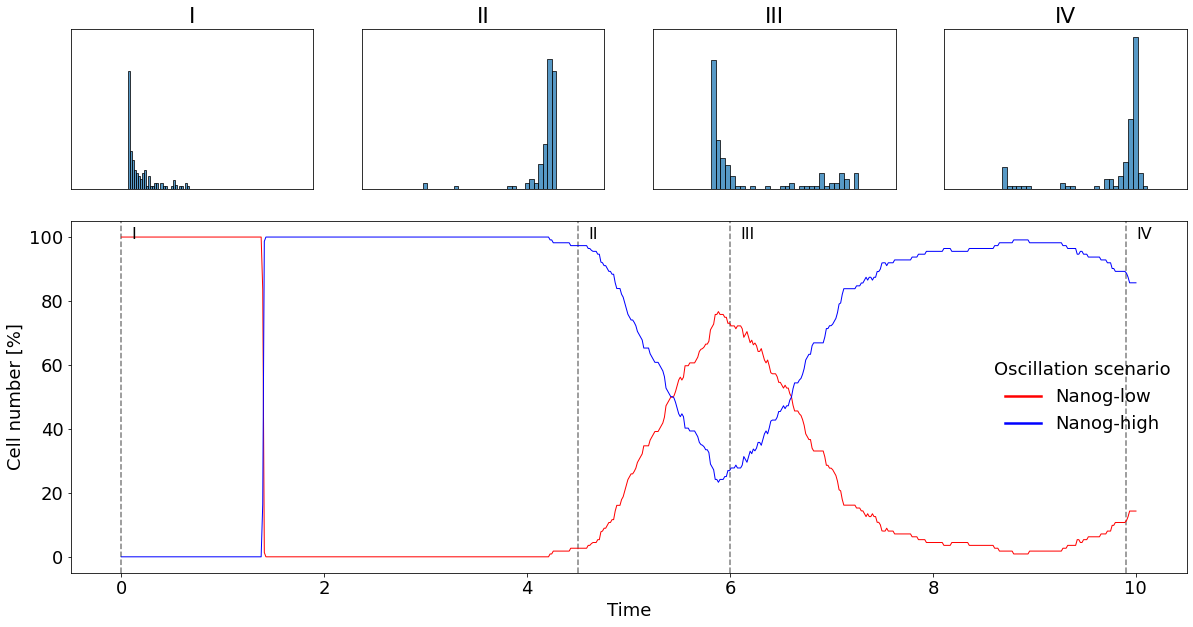

In [19]:
sample_time_points = [.0, .45, .6, 0.99] # fraction ofs tf_eval at which distributions will be plotted

# plot results
plt_timecourse(t_course_osc_n_low, 10, sample_time_points, 'Oscillation scenario')

In [530]:
# nanog high
num_n_high_cells = n_high_cells.shape[0]

# prepare inputs for parallel processor
args = [(osc_model, tf_eval, [n_high_cells[i], OS_0, X_0], dt, params_osc) for i in range(num_n_high_cells)]
inputs = zip(list(range(num_n_high_cells)), args)

# run population simulation on all available cpus
with mp.Pool(mp.cpu_count()) as pool:
    t_course_osc_n_high = np.asarray(pool.starmap(solve_and_return_nanog_values, tqdm(inputs, total=num_n_high_cells), chunksize=1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3211/3211 [04:41<00:00, 11.42it/s]


In [531]:
# save results to disk
np.save("./data/time_course_osc_nanog_high", t_course_osc_n_high)

In [20]:
# load results from disk
# t_course_osc_n_high = np.load("./data/time_course_osc_nanog_high.npy")

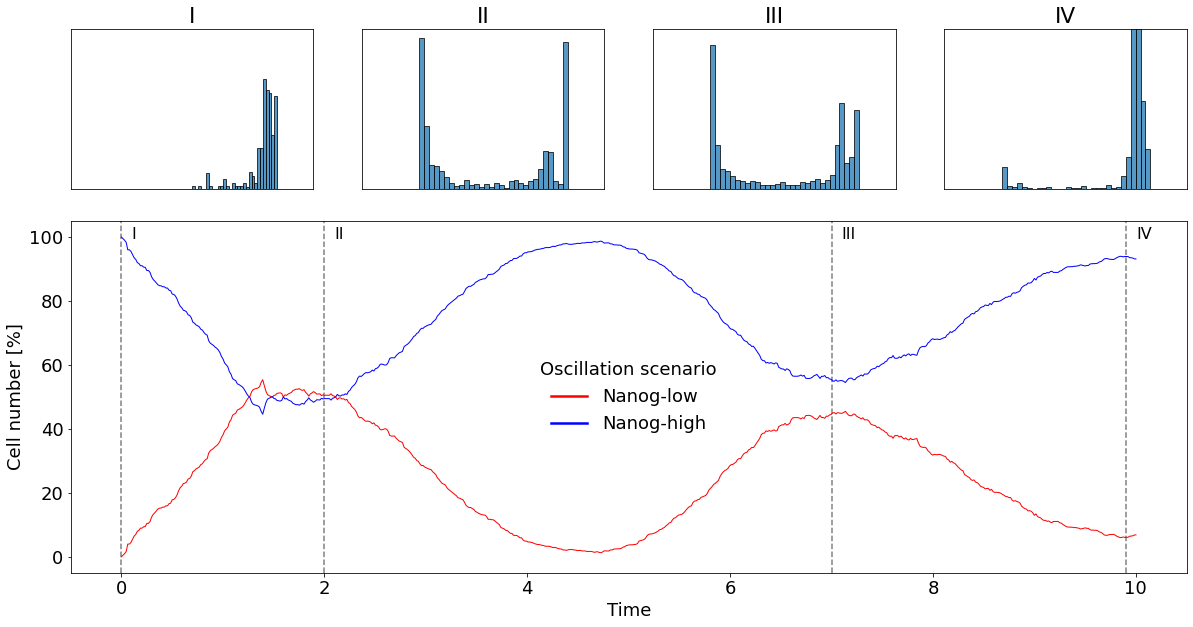

In [21]:
sample_time_points = [.0, .2, .7, 0.99] # fraction ofs tf_eval at which distributions will be plotted

# plot results
plt_timecourse(t_course_osc_n_high, 10, sample_time_points, 'Oscillation scenario')

# Model Differentiation Signal Y

In [43]:
def dOS_gate(OS, N, Y, p):
        
    oct4 = (p['s_1'] * OS**p['g_OS']) / ((p['k_1'] + OS**p['g_OS']) * p['d_O'])
    sox2 = (p['s_2'] * OS**p['g_OS']) / ((p['k_2'] + OS**p['g_OS']) * p['d_S'])
    decay = p['d_OS'] * OS
    oct4_sox2 = p['u'] * (oct4 * sox2) - (Y * p['l'] * 1/N)
    
    return oct4_sox2 - decay

In [44]:
def gate_model_stoch(step, y, dt, args):

    N, OS, Y = y
    
    N += dt * dN_stoch(N, OS, args)
    OS += dt * dOS_gate(OS, N, Y, args)
    
    if OS < 0: OS = 0
    if N < 0: N = 0
    
    return [N, OS]

In [45]:
def gate_model_osc(step, y, dt, args):

    N, OS, X, Y = y
    
    N += dt * dN_osc(N, OS, X, args)
    OS += dt * dOS_gate(OS, N, Y, args)
    X += dt * dX(X, N, args)
    
    if OS < 0: OS = 0
    if N < 0: N = 0
    
    return [N, OS, X]

In [46]:
# amend _solve function to be able to keep track of current step so triggering of singal y can be timed
def _solve_with_diff_signal(model, tf, y0, dt, diff_sig, args):
    
    t_norm_factor = args['f']
    steps = int(tf*t_norm_factor / dt)
    
    t = np.linspace(0, tf, steps)
    y = []
    
    diff_start = int(steps * diff_sig[0])
    diff_end = int(steps * diff_sig[1])
    
    for i in range(steps):
        _y = y[i-1].copy() if i > 0 else y0
        
        # append diff signal state to _y array depending on current step
        diff_sig_state = 0 if i < diff_start or i > diff_end else 1 
        _y.append(diff_sig_state)        
        
        res = model(i, _y, dt, args)
        y.append(res)
        
    return {'t': np.asarray(t), 'y': np.asarray(y)}


In [47]:
def plot_traj_with_signal(data):
    
    # define color of signal period
    sig_color = (1.0, 0, 0, 0.5)
    
    # draw tf levels
    plt.plot(data['t'], data['y'].T[0], 'g-', linewidth=2, label='nanog')
    plt.plot(data['t'], data['y'].T[1], 'r-', linewidth=2, label='os')
    
    if data['y'].T.shape[0] == 3:
        plt.plot(data['t'], data['y'].T[2], 'b-', linewidth=2, label='X')
    
    # draw signal period
    plt.fill_between([diff_start*tf, diff_end*tf], 0, 100, color=sig_color, label="Differentiation signal Y")
    
    plt.xlabel('time')
    plt.ylabel('level')
    plt.ylim(bottom=10**-2, top=10**3)
    plt.yscale("log")
    plt.legend()

# Stochastic Szenario

# set simulation parameters

In [499]:
# copy stoch params
params_stage_stoch = params_stoch.copy() 

# append factor l to parmas which controls strength of (negative) influence of nanog on oct_sox
params_stage_stoch['l'] = 10

In [500]:
# simulation parameters
dt = 0.0038
tf = 25

# initial conditions
OS_0 = 53.117
N_0 = 30

# Nanog Levels high when signal is induced

In [501]:
# fix np seed so results are reproducible
np.random.seed(42)

# define signal
diff_start = 12 / 25
diff_end = 13 / 25
diff_sig = [diff_start, diff_end]

# calculate trajectory
traj1 = _solve_with_diff_signal(
    gate_model_stoch, 
    tf, 
    [N_0, OS_0], 
    dt, 
    diff_sig,
    params_stage_stoch
)

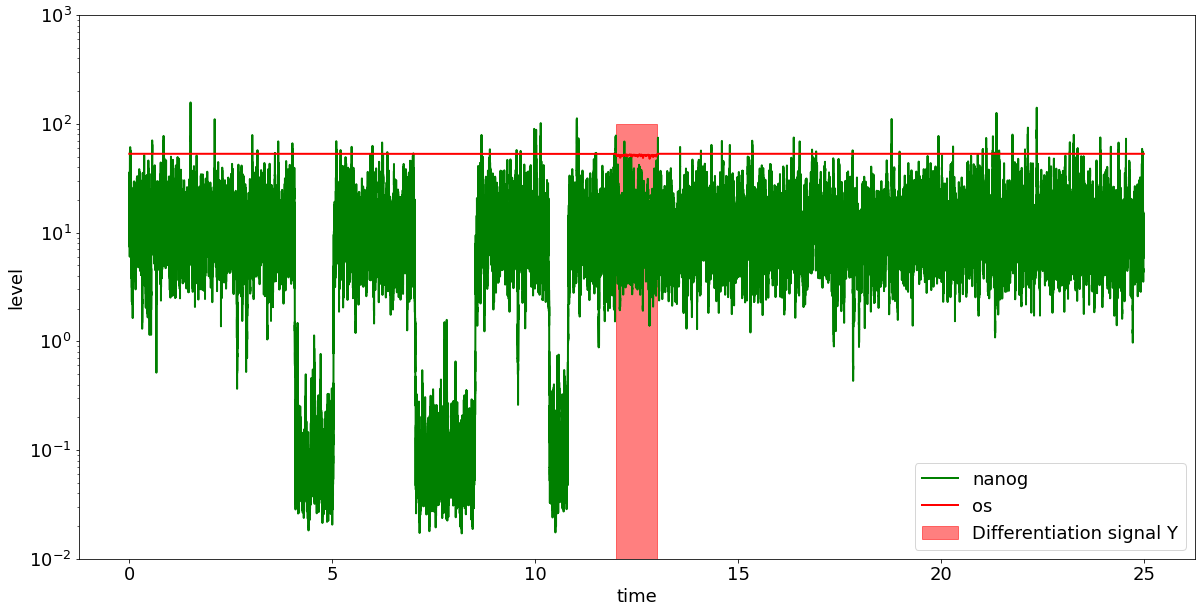

In [502]:
plot_traj_with_signal(traj1)

# Nanog Levels low when signal is induced

In [503]:
# fix np seed so results are reproducible
np.random.seed(42)

# define signal
diff_start = 8 / 25
diff_end = 9 / 25
diff_sig = [diff_start, diff_end]

# calculate trajectory
traj2 = _solve_with_diff_signal(
    gate_model_stoch, 
    tf, 
    [N_0, OS_0], 
    dt, 
    diff_sig,
    params_stage_stoch
)

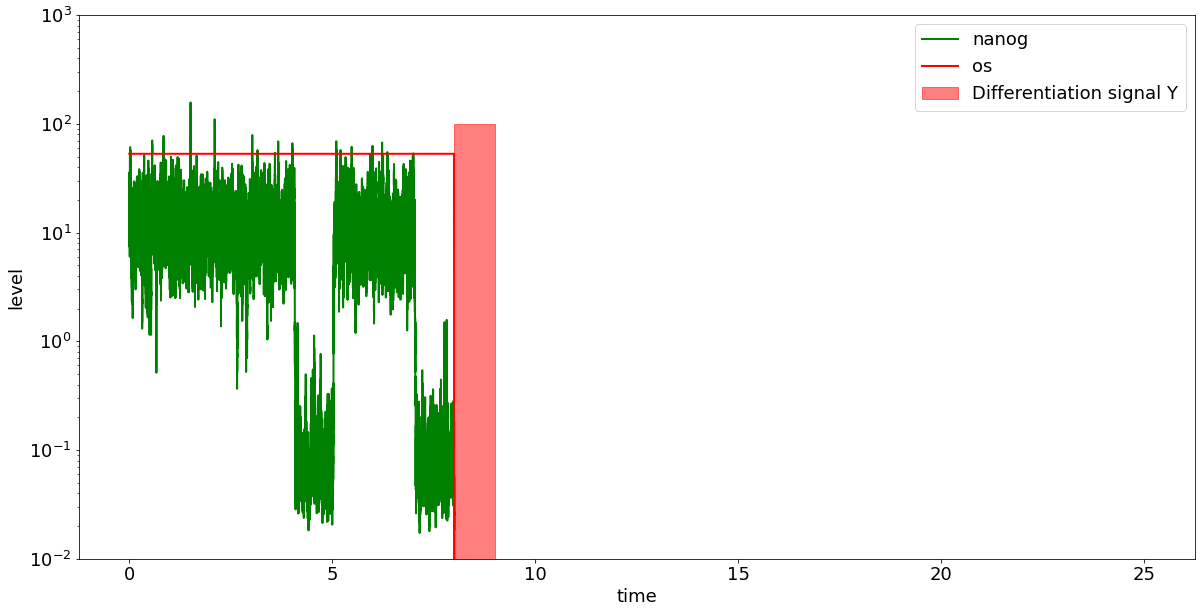

In [504]:
plot_traj_with_signal(traj2)

# Oscillation Szenario

### set simulation parameters

In [51]:
# copy stoch params
params_stage_osc = params_osc.copy() 

# append factor l to parmas which controls strength of (negative) influence of nanog on oct_sox
params_stage_osc['l'] = 10

In [52]:
# simulation parameters
dt = 0.0038
tf = 25

# initial conditions
OS_0 = 53.117
N_0 = 30
X_0 = OS_0

# Nanog Levels high when signal is induced

In [53]:
# fix np seed so results are reproducible
np.random.seed(42)

# define signal
diff_start = 9 / 25
diff_end = 10 / 25
diff_sig = [diff_start, diff_end]

# calculate trajectory
traj1 = _solve_with_diff_signal(
    gate_model_osc, 
    tf, 
    [N_0, OS_0, X_0], 
    dt, 
    diff_sig,
    params_stage_osc
)

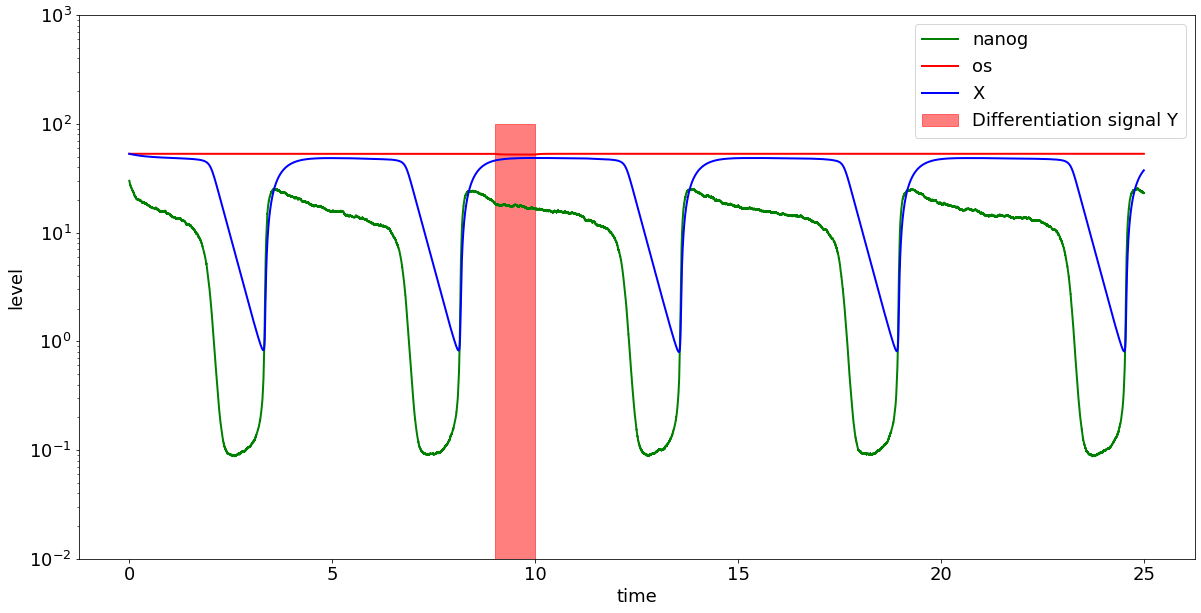

In [54]:
plot_traj_with_signal(traj1)

# Nanog Levels low when signal is induced

In [57]:
# fix np seed so results are reproducible
np.random.seed(42)

# define signal
diff_start = 13 / 25
diff_end = 14 / 25
diff_sig = [diff_start, diff_end]

# calculate trajectory
traj2 = _solve_with_diff_signal(
    gate_model_osc, 
    tf, 
    [N_0, OS_0, X_0], 
    dt, 
    diff_sig,
    params_stage_osc
)

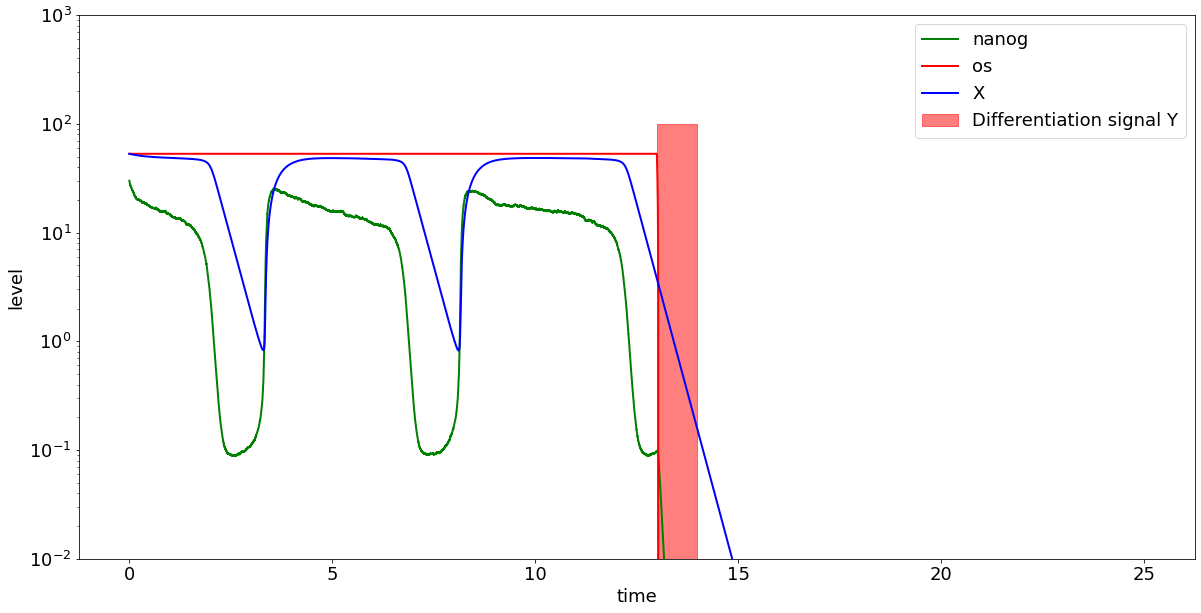

In [58]:
plot_traj_with_signal(traj2)